# Jupyter Notebook magic to make plots appear in line

In [1]:
%matplotlib inline

# Library imports

In [2]:
from Bio import Phylo
from Bio import SeqIO

import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']

# Read in the LTP phylogenetic tree
And inspect it to make sure it contains what we think it does

In [3]:
tree = Phylo.read('./LTPs123_LSU_tree.newick', 'newick')

In [4]:
print(len(tree.get_terminals()))

1614


In [5]:
for i in tree.get_terminals()[:5]:
    print(i.name)
    

Aeromonas_hydrophila_subsp._anaerogenes__AF508058__Aeromonadaceae
Aeromonas_hydrophila_subsp._hydrophila__CP000462__Aeromonadaceae
Aeromonas_media__AF508059__Aeromonadaceae
Aeromonas_salmonicida_subsp._salmonicida__AY987630__Aeromonadaceae
Aeromonas_salmonicida_subsp._pectinolytica__ARYZ01000149__Aeromonadaceae


# Read in the LTP aligned fasta sequences
And inspect it

In [6]:
records = list(SeqIO.parse('./LTPs123_LSU_aligned.fasta', 'fasta'))

In [7]:
print(len(records))

1614


In [8]:
print(records[0])
# print(records[0].seq)

ID: AQXM01000063
Name: AQXM01000063
Description: AQXM01000063	138813	141952	3140bp	rna	Acaricomes phytoseiuli	Micrococcaceae
Number of features: 0
Seq('...........................................................A', SingleLetterAlphabet())


# Find *E. coli*

In [9]:
for i in records:
    if i.description.find('Escherichia') != -1:
        print(i.description)

AJ278710	1	2900	2900bp	rna	Escherichia coli	Enterobacteriaceae
CU928158	3876572	3879476	2905bp	rna	Escherichia fergusonii	Enterobacteriaceae


# Move the sequences over into a dictionary object to make handling them easier

In [10]:
sequence_dict = {}
for record in records:
    sequence_dict[record.id] = record.seq

In [11]:
print('There are {} sequences total and the length of the aligned E. coli sequence is {}'\
      .format(len(sequence_dict.keys()), len(sequence_dict['AJ278710'])))

There are 1614 sequences total and the length of the aligned E. coli sequence is 11079


# Create a separate dictionary to match the names in the tree to their sequence record id's
I'm doing this inefficiently but it runs quick enough so not too concerning

In [12]:
name_conversion_dict = {}
for i in sequence_dict.keys():
#     print(i)
    i_counts = 0
    for terminal in tree.get_terminals():
        if terminal.name.find(i) != -1:
            name_conversion_dict[terminal.name] = i
            i_counts += 1
    if i_counts != 1: ### Make sure that I find one and only one match for each record
        print(i, i_counts)

# This little dictionary will map the traditional E. coli positions to their positions in the aligned sequences (i.e. dealing with all the gaps that exist in the aligned sequences)

In [13]:
mapping_dict = {}
starting_point = 0
nt_seq = []
for i,nt in enumerate(list(str(sequence_dict['AJ278710']))):
    if nt in ['A', 'U', 'G', 'C']:
        nt_seq.append(nt)
        starting_point += 1
        mapping_dict[starting_point] = i


# Get the ungapped 23s E. coli sequence to aid in finding regions of interest

In [14]:
ec_nt = ''.join(nt_seq)
print('5\' region')
print(ec_nt[:100])
print('3\' region')
print(ec_nt[-100:])

5' region
UAAGCGACUAAGCGUACACGGUGGAUGCCCUGGCAGUCAGAGGCGAUGAAGGACGUGCUAAUCUGCGAUAAGCGUCGGUGAGGUGAUAUGAACCGUUAUA
3' region
CCUGAAGGAACGUUGAAGACGACGACGUUGAUAGGCCGGGUGUGUAAGCGCAGCGAUGCGUUGAGCUAACCGGUACUAAUGAACCGUGAGGCUUAACCUU


# Alright this step took a fair bit of manual effort to find the location of motifs of interest in the E. coli sequence so I'm just including one as an example so you get the idea

In [15]:
# target_seq = 'GAAAGAC'
# target_seq = 'GAUAACAGGC'
target_seq = 'CACCUCGAUGUC'
# target_seq = 'GGUUUAG'
# target_seq = 'CGGUCCC'
# target_seq = 'AGUUCGGUCCC'
# target_seq = 'UGGCUGUUCGCCA'

ec_nt.find(target_seq)

2491

In [16]:
for i in range(2491, 2491+len(target_seq)+1):
    print(mapping_dict[i])

9597
9598
9599
9600
9601
9602
9603
9605
9606
9607
9608
9609
9610


# Summarizing the interesting regions
From all the manual work above here are some of the regions that I identified

In [17]:
#####Checking out an individual region
region_of_interest = list(range(9598, 9604))+list(range(9605,9611))
region_name = 'region3'

#####Combining them all
# region_of_interest_1 = [9073] + list(range(9075, 9081))
# region_of_interest_2 = list(range(9543, 9546))+list(range(9548, 9555))
# region_of_interest_3 = list(range(9598, 9604))+list(range(9605,9611))
# region_of_interest_4 = list(range(9693, 9698)) + list(range(9699,9701))
# region_of_interest_5 = list(range(9715, 9716))
# region_of_interest_6 = [9773] + list(range(9775, 9778)) + list(range(9780,9782))
# region_of_interest = region_of_interest_1 + region_of_interest_2 + region_of_interest_3 +\
#                         region_of_interest_4 + region_of_interest_5 + region_of_interest_6
# region_name = 'all'

# Making the matrix for visualization
I convert the categorical values (nucleotides) into numbers to make the heatmap

In [18]:
matrix = []

for terminal in tree.get_terminals():
    i = name_conversion_dict[terminal.name]
    j = sequence_dict[i]
    tempy = []
    if len(j) > 1600:
        for nt_pos in region_of_interest:
            nt = j[nt_pos]
            if nt == 'U':
                tempy.append(1)
            elif nt == 'C':
                tempy.append(0.5)
            elif nt == 'A':
                tempy.append(0)
            elif nt == 'G':
                tempy.append(-0.5)
            else:
                tempy.append(-1)
        matrix.append(tempy)

In [19]:
print('Double checking that my matrix has {} rows and {} columns'.format(len(matrix), len(matrix[0])))

Double checking that my matrix has 1614 rows and 12 columns


# Plotting

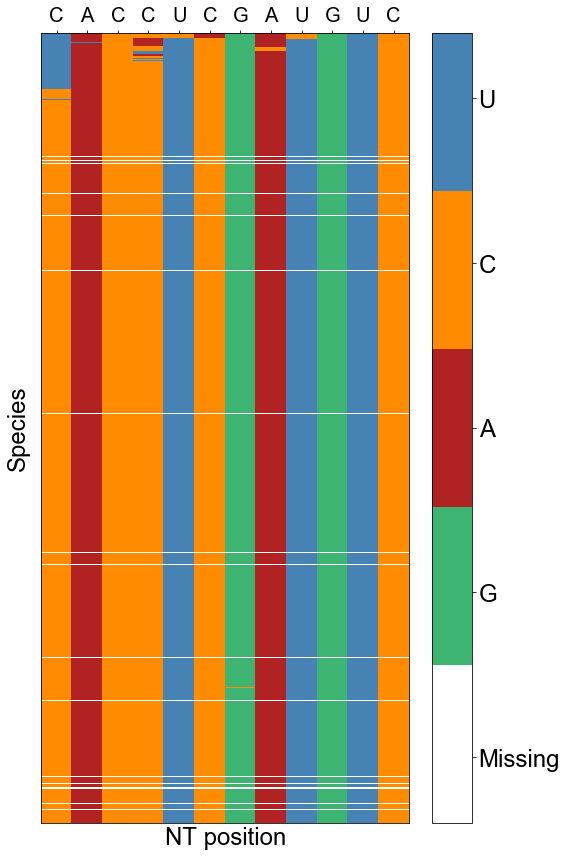

In [20]:
fig, ax = plt.subplots(figsize=(3+(9*(len(matrix[0])/22)),12))

# define the colormap
cmap = plt.cm.jet
cmaplist = ['white', 'mediumseagreen', 'firebrick', 'darkorange', 'steelblue']
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-1.2, 1.2, 6)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cax = ax.pcolormesh(matrix, norm=norm, cmap=cmap)
cax.set_edgecolor('face')
cbar = fig.colorbar(cax, ticks=[-1, -0.5, 0, 0.5, 1])
cbar.ax.set_yticklabels(['Missing', 'G', 'A', 'C', 'U'], fontsize=24)
ax.set_xticks([i+0.5 for i in range(len(matrix[0]))])
ax.set_xticklabels([sequence_dict['AJ278710'][i] for i in region_of_interest])
ax.xaxis.tick_top()
ax.set_xlabel('NT position', fontsize=24)
ax.set_ylabel('Species', fontsize=24)
ax.tick_params(labelsize=20)
ax.set_yticklabels('')
for line in ax.yaxis.get_ticklines():
    line.set_markersize(0)
    line.set_markeredgewidth(0)
plt.tight_layout()
# plt.savefig('./{}.pdf'.format(region_name))

# Calculating entropies

In [21]:
positions = []
entropies = []
missing = []
for pos, i in enumerate(np.array(matrix).T):
    tempy = []
    for nt in i:
        if nt in [1, 0.5, 0, -0.5]:
            tempy.append(nt)
    ps = [tempy.count(i)/len(tempy) for i in [1, 0.5, 0, -0.5]]
    entropies.append(stats.entropy(ps))
    positions.append(pos)

# Plotting entropies and saving values in a dataframe

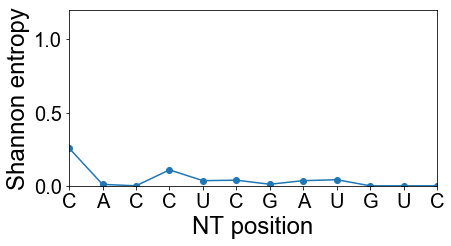

In [22]:
fig, ax = plt.subplots(figsize=(2+(8*(len(matrix[0])/22)),3.5))
ax.plot(positions, entropies, marker='o')
ax.set_xticks([i for i in range(len(matrix[0]))])
ax.set_xticklabels([sequence_dict['AJ278710'][i] for i in region_of_interest])
ax.set_xlabel('NT position', fontsize=24)
ax.set_ylabel('Shannon entropy', fontsize=24)
ax.tick_params(labelsize=20)
ax.set_ylim(0, 1.2);
ax.set_xlim(0, len(entropies)-1)
plt.tight_layout()
# plt.savefig('./{}_entropies.pdf'.format(region_name))




df = pd.DataFrame()
counter = 0
for i in region_of_interest:
    j = sequence_dict['AJ278710'][i]
    df.set_value(i, 'NT', j)
    if j == '-':
        df.set_value(i, 'Entropy', np.nan)
        counter += 1
    else:
        df.set_value(i, 'Entropy', entropies[counter])
        counter += 1
# writer = pd.ExcelWriter('./{}_entropies.xlsx'.format(region_name))
# df.to_excel(writer,'Sheet1')
# writer.save()

# *fin.*